# Calibrating Quicksurvey using Gaussian Mixture Models

The goal of this notebook is to use noiseless spectroscopic simulations from `desitarget.select_mock_targets` to calibrate a set of Gaussian mixture models (GMMs) which can be used in turn to simulate much larger datasets just at the catalog level, i.e., *quicksurvey*.

In [1]:
import os
import warnings
import numpy as np
from pkg_resources import resource_filename

In [2]:
from astropy.table import Table
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

In [3]:
from desiutil.sklearn import GaussianMixtureModel
from desitarget.targetmask import desi_mask

In [4]:
import matplotlib.pyplot as plt
import corner as cn

In [5]:
%matplotlib inline

#### Simulation variables

In [6]:
seed = 1
rand = np.random.RandomState(seed)
overwrite = True

### Define some convenience functions for doing the Gaussian mixture modeling.

In [7]:
def get_mog_bic(X, ncomp, rand=None):
    """Compute the MoG and BIC for a range of Gaussian components."""
    mog = [GMM(n_components=nc, random_state=rand).fit(X) for nc in ncomp]
    bic = [_mog.bic(X) for _mog in mog]
    return mog, np.array(bic)

In [8]:
def qa_bic(ncomp, bic, title='Object', png=None):
    ncompbest = ncomp[np.argmin(bic)]
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ncomp, bic / 100, marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion / 100')
    ax.set_title('{}: Optimal number of components = {:d}'.format(title, ncompbest))
    if png:
        plt.savefig(png)

In [9]:
def build_gmm(X, ncompmin=1, ncompmax=5, target='', 
              rand=None, png=None, overwrite=False):
    """Find the optimal GMM."""

    if rand is None:
        rand = np.random.RandomState()
    ncomp = np.arange(ncompmin, ncompmax)

    gmmfile = resource_filename('desitarget', 'mock/data/quicksurvey_gmm_{}.fits'.format(
        target.lower()))
    if ~os.path.isfile(gmmfile) or overwrite:
        print('Generating a GMM for {}s with N={}-{} components from {} objects.'.format(
            target, ncompmin, ncompmax, X.shape[0]))
        allmog, bic = get_mog_bic(X, ncomp, rand=rand)
        qa_bic(ncomp, bic, png=png, title=target)    
    
        print('Writing {}'.format(gmmfile))
        mog = allmog[np.argmin(bic)] # minimize the BIC
        GaussianMixtureModel.save(mog, gmmfile)

    # (Re)read the model to get a few more convenience methods.
    print('Reading {}'.format(gmmfile))
    mog = GaussianMixtureModel.load(gmmfile)

    return mog

### Read the reference truth catalog.

In [10]:
def read_targets_truth():
    refdir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 
                          'reference_runs', '18.3', 'targets')
    truthfile = os.path.join(refdir, 'truth.fits')
    targetsfile = os.path.join(refdir, 'targets.fits')

    truth = Table.read(truthfile)#.to_pandas()
    print('Read {} objects from {}'.format(len(truth), truthfile))

    targets = Table.read(targetsfile)#.to_pandas()
    print('Read {} objects from {}'.format(len(targets), targetsfile))
    
    return targets, truth

In [11]:
targets, truth = read_targets_truth()
targets

Read 240902 objects from /Users/ioannis/work/desi/datachallenge/reference_runs/18.3/targets/truth.fits
Read 240902 objects from /Users/ioannis/work/desi/datachallenge/reference_runs/18.3/targets/targets.fits


BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SUBPRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,int64,int64,int64,int64
5261,1526p282,0,152.762924194,28.3125839233,4.87419,12.4022,21.5929,16.4725,10.9474,0.940107,0.95925,0.97681,0.99647,0.997831,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,-0.000956611,-0.000314208,0.000593837,0.452496,0.00100628,-0.00102234,0.356810355942,288230398217945088,1152921504606846976,65537,0,0
5261,1524p280,1,152.563858032,28.1027755737,21.6167,37.2972,55.9602,51.4054,38.1055,0.93063,0.952726,0.973057,0.995893,0.997476,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,3.15721,0.0556914,-0.000684553,0.866786,-0.106927,-0.0230106,0.568604199297,288230398217945089,1152921504606846976,131074,0,0
5261,1526p285,2,152.636505127,28.5471324921,18.8227,48.336,84.6381,76.4054,51.4296,0.948148,0.964769,0.979976,0.996956,0.99813,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,53.4724,0.164367,-0.0889053,0.393993,-0.256706,-0.0100387,0.93292545864,288230398217945090,1152921504606846976,131074,0,0
5261,1523p282,3,152.453033447,28.3228969574,17.3274,69.1105,146.392,176.067,125.94,0.939746,0.959002,0.976667,0.996449,0.997817,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,0.38233,-0.17208,-0.170571,-0.000191608,-0.00332903,-0.00330882,0.588079222788,288230398217945091,1152921504606846976,131074,0,0
5261,1529p282,4,152.821365356,28.337770462,1.97005,9.62195,21.3818,35.9626,27.7675,0.93711,0.957189,0.975626,0.996288,0.997719,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,-7.74865e-05,0.00207773,0.000594246,1.11604,0.119471,-0.221381,0.175434315238,288230398217945092,1152921504606846976,65537,0,0
5261,1526p282,5,152.510864258,28.2928829193,10.7094,22.8213,34.591,32.8464,26.5192,0.939185,0.958616,0.976446,0.996414,0.997796,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,1.983,-0.26877,0.390211,-0.000206943,5.04955e-05,4.57717e-05,0.365531304502,288230398217945093,1152921504606846976,131074,0,0
5261,1526p282,6,152.763931274,28.168346405,14.2403,37.6313,71.8919,77.2457,54.4891,0.931339,0.953214,0.973339,0.995936,0.997502,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,0.000777539,0.00166061,0.000351365,2.59296,0.0972936,-0.312624,0.951183062125,288230398217945094,1152921504606846976,131074,0,0
5261,1526p285,7,152.558761597,28.3912391663,3.47569,10.9017,21.2698,29.0895,20.245,0.942218,0.9607,0.977643,0.996598,0.99791,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,-0.000556191,0.000258831,-0.000925425,1.46512,0.181207,0.21468,0.167046833546,288230398217945095,1152921504606846976,65537,0,0
5261,1526p282,8,152.775146484,28.182674408,14.9511,65.0984,145.076,204.618,152.096,0.931753,0.9535,0.973503,0.995961,0.997518,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,0.00235169,-0.000887671,-0.000431117,2.06847,0.0883114,0.104788,0.680662990024,288230398217945096,1152921504606846976,131074,0,0


In [12]:
truth

TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,VDISP,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
int64,int64,int64,float32,str10,str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
288230398217945088,15594312,0,0.134829,GALAXY,BGS,,3627,1482857632,19.8104,61.5363,5.24496,13.0271,22.0723,17.0456,11.0778,-1.0,0.0,-1.0,-1.0,-1.0
288230398217945089,19713506,0,0.131031,GALAXY,BGS,,3100,1847516324,18.5536,61.5363,23.2365,39.1643,57.4299,52.1437,38.0304,-1.0,1.62485e-15,-1.0,-1.0,-1.0
288230398217945090,17928726,0,0.145801,GALAXY,BGS,,1281,1159188526,18.3514,61.5363,19.8501,50.1084,86.5181,74.6362,51.4383,-1.0,0.0,-1.0,-1.0,-1.0
288230398217945091,19762079,0,0.295097,GALAXY,BGS,,5168,1664239784,17.9932,61.5363,18.4524,71.9985,149.989,178.462,126.497,-1.0,0.0,-1.0,-1.0,-1.0
288230398217945092,13979089,0,0.404595,GALAXY,BGS,,6077,236582212,20.1547,61.5363,2.09978,9.95809,21.8389,36.396,28.0412,-1.0,0.0,-1.0,-1.0,-1.0
288230398217945093,16459200,0,0.264106,GALAXY,BGS,,1126,1991162537,19.1176,61.5363,11.3866,23.7894,35.4239,33.6405,26.4355,-1.0,6.34972e-16,-1.0,-1.0,-1.0
288230398217945094,18522434,0,0.124415,GALAXY,BGS,,5431,266394818,18.6124,61.5363,15.305,39.5149,73.9385,79.3565,54.7434,-1.0,1.20094e-16,-1.0,-1.0,-1.0
288230398217945095,17843316,0,0.32049,GALAXY,BGS,,891,465634076,19.9593,61.5363,3.73762,11.398,21.8683,27.3294,20.5494,-1.0,8.81773e-17,-1.0,-1.0,-1.0
288230398217945096,16440187,0,0.294273,GALAXY,BGS,,3795,1715747948,18.0603,61.5363,16.0364,68.1686,149.188,206.879,152.196,-1.0,0.0,-1.0,-1.0,-1.0


### Define some wrapper functions for reading the data and generating QA.

In [13]:
def get_data(target='ELG', dataframe=False, Nmax=None):
    """Build the data matrix."""
    from desitarget.targetmask import desi_mask, mws_mask, bgs_mask
    
    if target == 'LYA':
        indx = ( ((targets['DESI_TARGET'].data & desi_mask.QSO) != 0) *
                 (np.char.strip(truth['TEMPLATESUBTYPE']) == 'LYA') )
    else:
        if 'BGS' in target:
            indx = ( ((targets['DESI_TARGET'] & desi_mask.BGS_ANY) != 0) *
                    (np.char.strip(truth['TEMPLATETYPE']) == 'BGS') )
        else:
            indx = ( ((targets['DESI_TARGET'] & desi_mask.mask(target)) != 0) *
                    (np.char.strip(truth['TEMPLATETYPE']) == target) )
                
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        gmag = 22.5 - 2.5 * np.log10(truth['FLUX_G'][indx])
        rmag = 22.5 - 2.5 * np.log10(truth['FLUX_R'][indx])
        zmag = 22.5 - 2.5 * np.log10(truth['FLUX_Z'][indx])
        gr = - 2.5 * np.log10(truth['FLUX_G'][indx] / truth['FLUX_R'][indx])
        rz = - 2.5 * np.log10(truth['FLUX_R'][indx] / truth['FLUX_Z'][indx])
        zW1 = - 2.5 * np.log10(truth['FLUX_Z'][indx] / truth['FLUX_W1'][indx])
        W1W2 = - 2.5 * np.log10(truth['FLUX_W1'][indx] / truth['FLUX_W2'][indx])
        oii = np.log10(1e17 * truth['OIIFLUX'][indx])
        
    if dataframe:
        import pandas as pd
        df = pd.DataFrame()
        df['g - r'] = gr
        df['r - z'] = rz
        df['z - W1'] = zW1
        df['W1 - W2'] = W1W2
        if target == 'ELG':
            df['r'] = rmag
            df['[OII]'] = oii
        elif target == 'LRG':
            df['z'] = zmag
        elif target == 'QSO' or target == 'LYA':
            df['g'] = gmag
            
        if Nmax:
            df = df[:Nmax]
            
        return df
    else:
        nobj = len(indx)
        X = np.vstack( (gr, rz, zW1, W1W2) )
        if target == 'ELG':
            X = np.vstack( (rmag, X, oii) )
        elif target == 'BGS':
            X = np.vstack( (rmag, X) )
        elif target == 'LRG':
            X = np.vstack( (zmag, X) )
        elif target == 'QSO':
            X = np.vstack( (gmag, X) )
        elif target == 'LYA':
            X = np.vstack( (gmag, X) )

        if Nmax:
            X = X[:, :Nmax]
            
        return X.T

In [14]:
def qa_corner(Xdata, Xsample, target=''):
    if target == 'ELG':
        labels = ('r', 'g - r', 'r - z', 'z - W1', 'W1 - W2', r'log$_{10}$ [OII]-17')
    elif target == 'BGS':
        labels = ('r', 'g - r', 'r - z', 'z - W1', 'W1 - W2')
    elif target == 'LRG':
        labels = ('z', 'g - r', 'r - z', 'z - W1', 'W1 - W2')
    elif target == 'QSO':
        labels = ('g', 'g - r', 'r - z', 'z - W1', 'W1 - W2')
    elif target == 'LYA':
        labels = ('g', 'g - r', 'r - z', 'z - W1', 'W1 - W2')
    
    fig = cn.corner(Xdata, labels=labels, label_kwargs={"fontsize": 14}, 
                    show_titles=True, title_kwargs={"fontsize": 12},
                    color='k')
    fig.suptitle('{} Validation Data (grayscale) + GMM Samples (green points)'.format(target.upper()))
    
    nobj, ndim = Xdata.shape
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.scatter(Xsample[:, xi], Xsample[:, yi], marker='s', 
                       color='g', s=5, alpha=0.5)

In [15]:
def train_and_validate(target, Nsample=500, overwrite=False):
    X = get_data(target.upper(), Nmax=20000)
    Xtrain, Xvalidate = train_test_split(X, test_size=0.5, random_state=rand)
    
    mog = build_gmm(Xtrain, ncompmin=3, ncompmax=50, overwrite=overwrite, 
                    target=target, rand=rand, png=None)
    
    Xsample = mog.sample(Nsample, random_state=rand)
    qa_corner(Xvalidate, Xsample, target=target)
    
    return mog

### BGS

Generating a GMM for BGSs with N=3-50 components from 10000 objects.
Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_bgs.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_bgs.fits
CPU times: user 5min 24s, sys: 5.63 s, total: 5min 30s
Wall time: 1min 24s


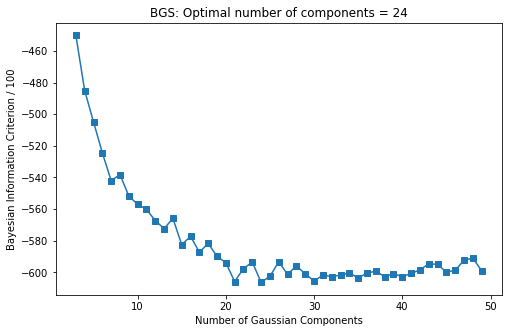

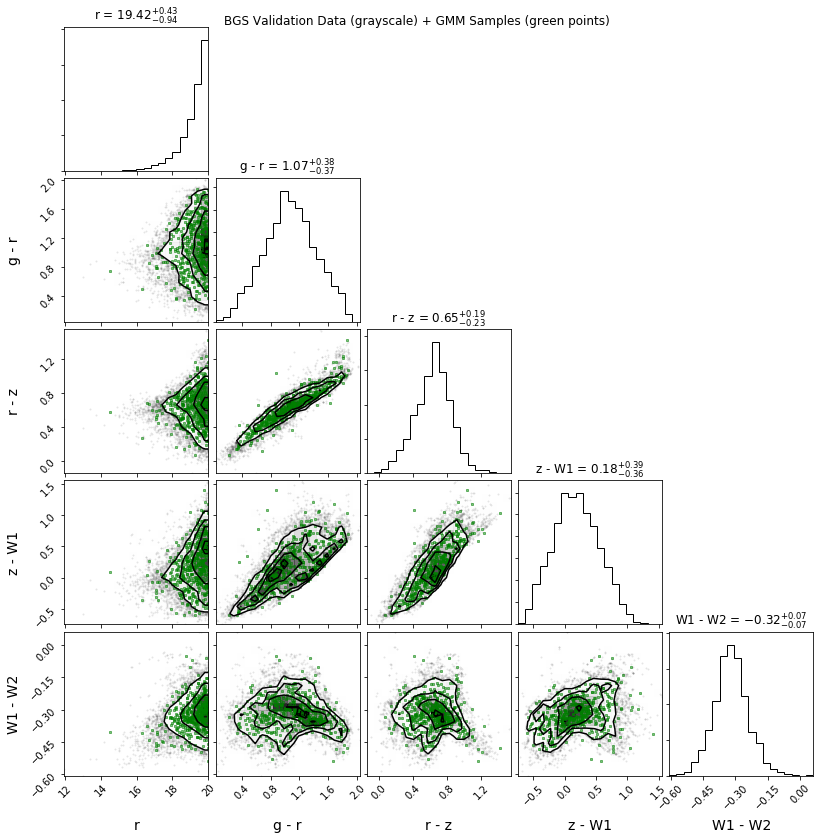

In [16]:
%time mog = train_and_validate('BGS', Nsample=500, overwrite=overwrite)

### LYAs
Train a GMM on *g*, *g-r*, *r-z*, *z-W1*, and *W1-W2*.

Generating a GMM for LYAs with N=3-50 components from 1044 objects.
Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_lya.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_lya.fits
CPU times: user 47.3 s, sys: 348 ms, total: 47.6 s
Wall time: 12.9 s


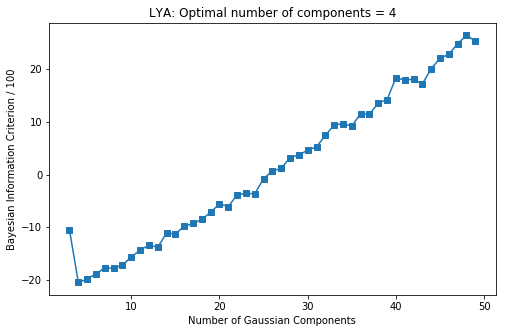

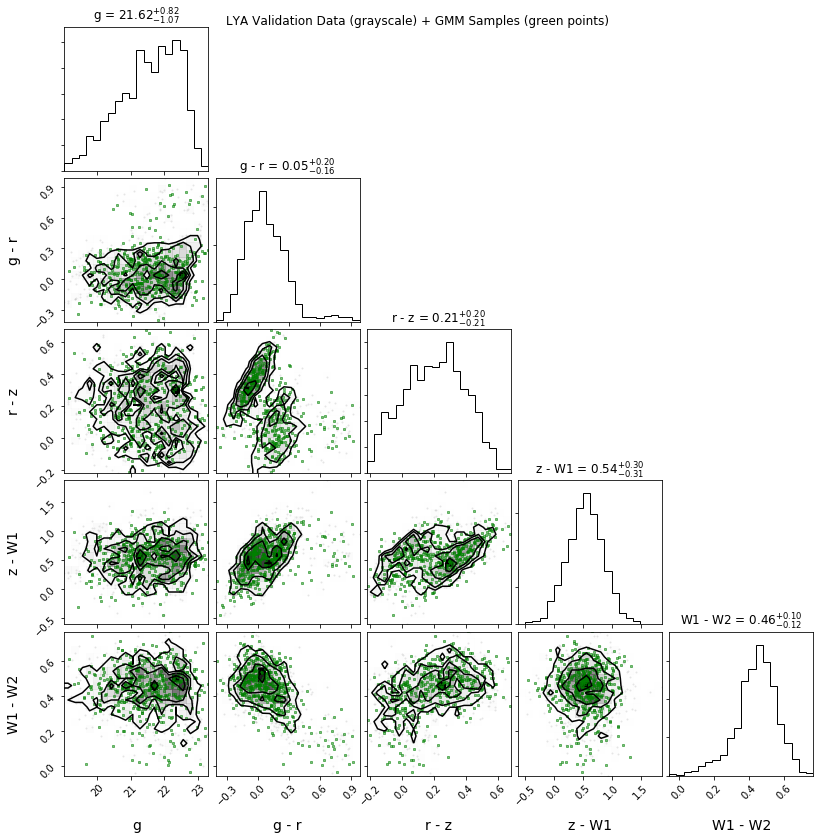

In [17]:
%time mog = train_and_validate('LYA', Nsample=500, overwrite=overwrite)

### QSOs

Train a GMM on *g*, *g-r*, *r-z*, *z-W1*, and *W1-W2*.

Generating a GMM for QSOs with N=3-50 components from 3444 objects.
Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_qso.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_qso.fits
CPU times: user 2min 30s, sys: 1.83 s, total: 2min 32s
Wall time: 39.1 s


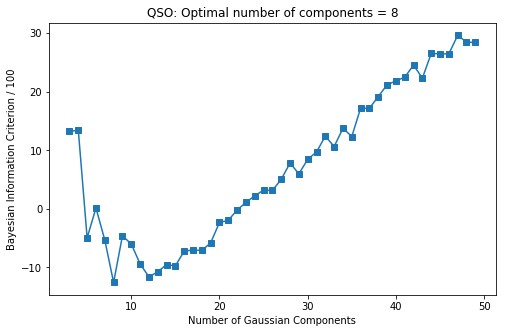

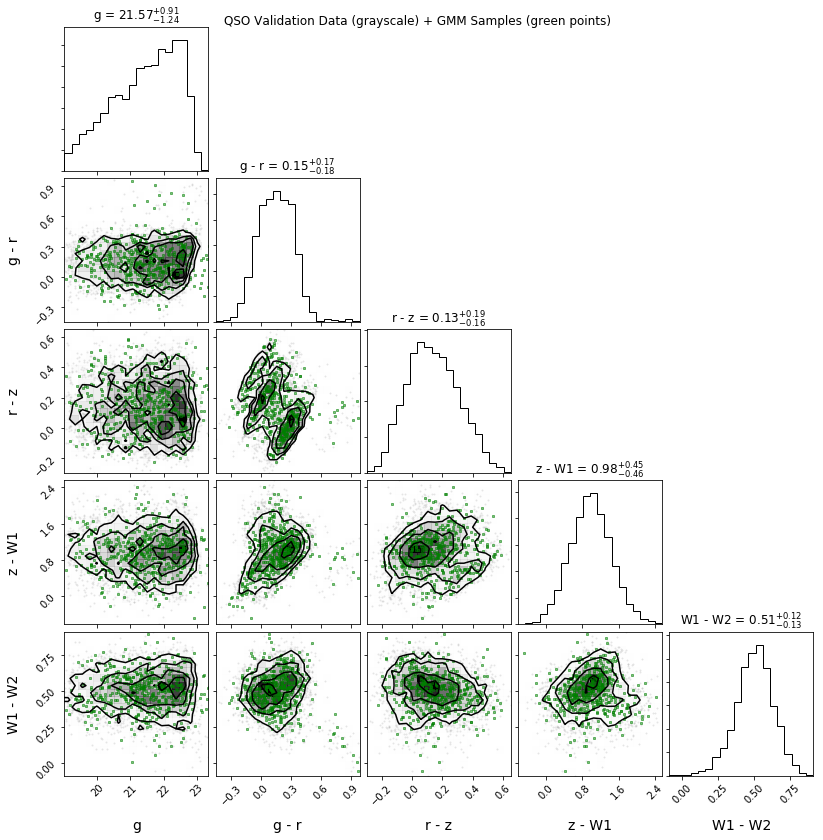

In [18]:
%time mog = train_and_validate('QSO', Nsample=500, overwrite=overwrite)

### LRGs

Train a GMM on *z*, *g-r*, *r-z*, *z-W1*, and *W1-W2*.

Generating a GMM for LRGs with N=3-50 components from 7721 objects.


/usr/local/anaconda3/envs/desi/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_lrg.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_lrg.fits
CPU times: user 4min 50s, sys: 3.67 s, total: 4min 54s
Wall time: 1min 14s


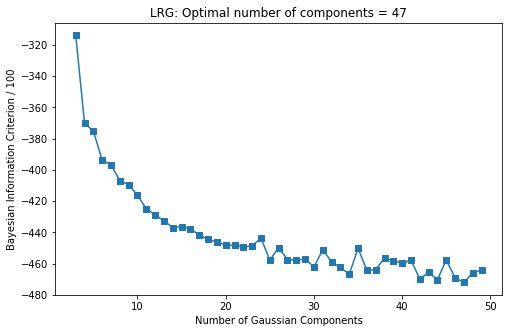

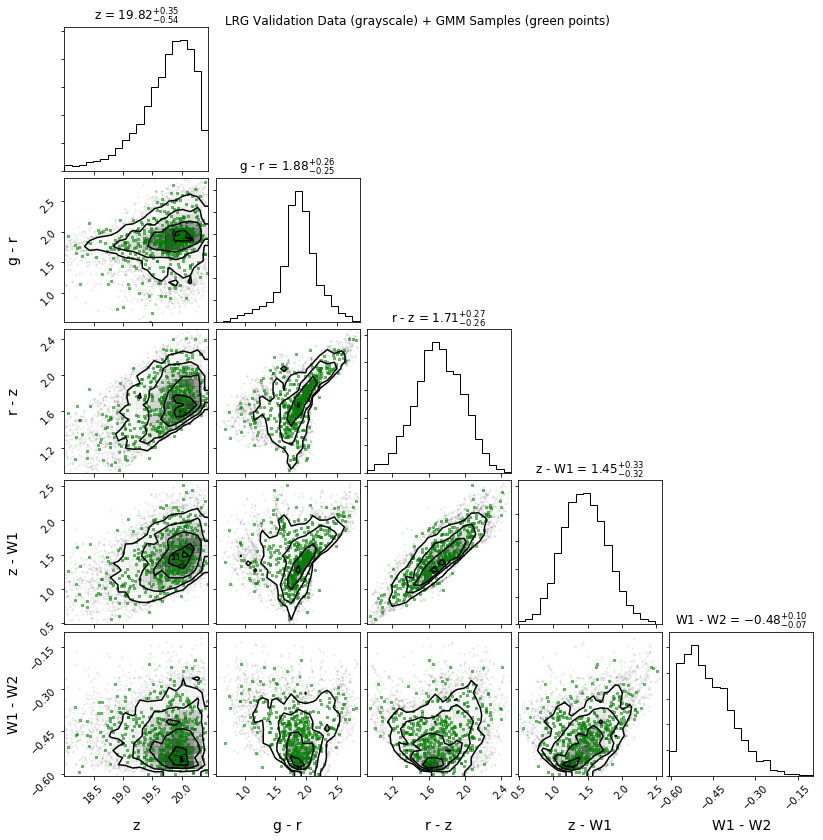

In [19]:
%time mog = train_and_validate('LRG', Nsample=500, overwrite=overwrite)

### ELGs

Train a GMM on *r*, *g-r*, *r-z*, *z-W1*, *W1-W2*, and *[OII] flux*.

Generating a GMM for ELGs with N=3-50 components from 10000 objects.


/usr/local/anaconda3/envs/desi/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_elg.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_elg.fits
CPU times: user 8min 48s, sys: 8.91 s, total: 8min 57s
Wall time: 2min 16s


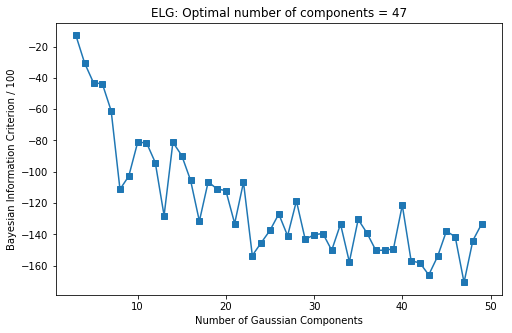

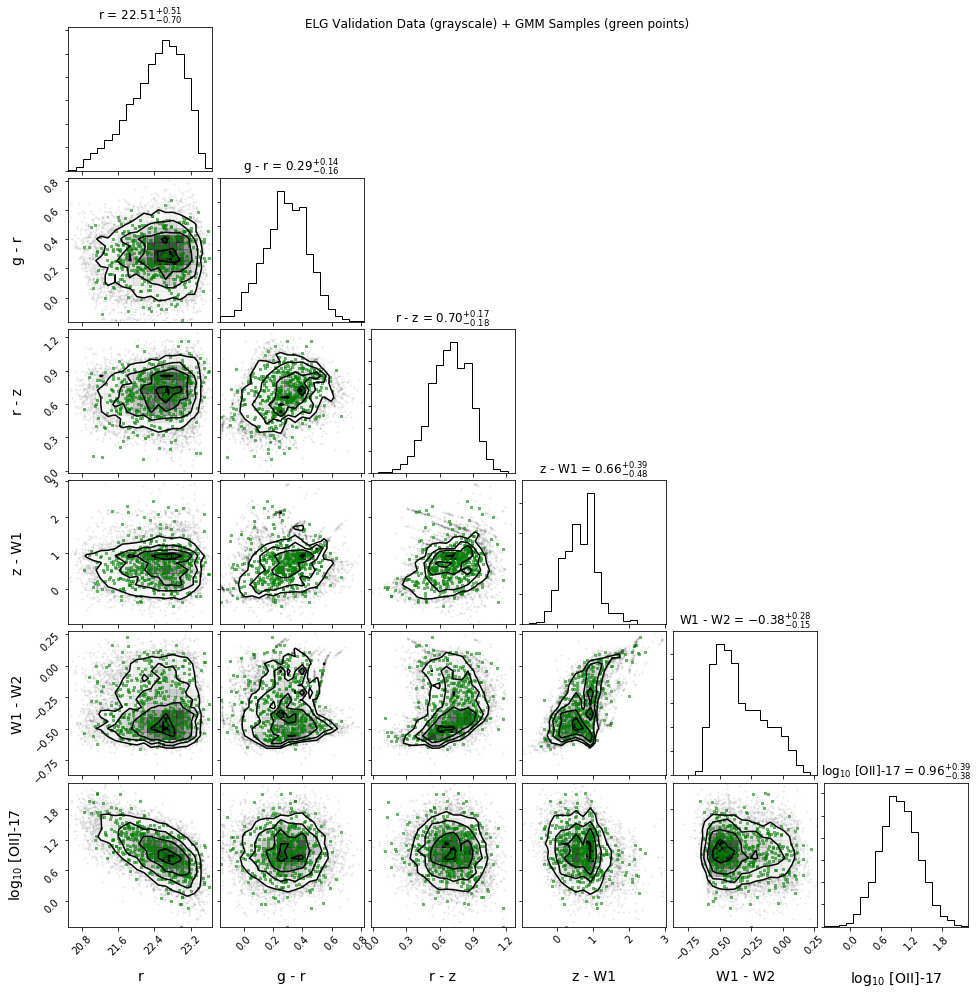

In [20]:
%time mog = train_and_validate('ELG', Nsample=500, overwrite=overwrite)